---
## Notebook for `squential` power analysis of all 
* This notebook reads the data from the sequential analysis
* It has two main plots one for a single service and one for comparing two services
* All metrics can be plotted: `power`, `delta` and `energy` for all applications
* All figures are automatically saved in the directory `plots/`


---
### Read Data: Save Sequential Data to the `data_dict` Variable
* Reads the data from the `data/out` directory
* Saves the data to the `data_dict` variable

In [2]:
import pandas as pd
import os

SERVICES  = ['python-flask', 'rust-actix', 'go-gorilla'] # rust-actix
base_dir = 'data/out'
dir_out = 'plots/'
data_dict = {}

def merge_with_power(df_api, df_page, df_power):
    """
    Merge both df_api and df_page with df_power sequentially.
    """
    # Ensure DataFrames are sorted by their time columns
    df_power = df_power.sort_values("timestamp")
    df_api = df_api.sort_values("start")
    df_page = df_page.sort_values("start")
    
    # Merge API data with power
    merged_api = pd.merge_asof(
        df_power,
        df_api,
        left_on="timestamp",
        right_on="start",
        direction="forward",
    )
    
    split_index = merged_api[merged_api['endpoint'].isna()].index.min()
    
    df_power_split = df_power.iloc[split_index:]
    
    # Merge Page data with the second half of df_power
    merged_page = pd.merge_asof(
        df_power_split,
        df_page,
        left_on="timestamp",
        right_on="start",
        direction="forward"
    )
    
    df_merged = pd.concat([merged_api, merged_page], ignore_index=True)
    df_merged = df_merged.dropna(subset=['endpoint'])
    return df_merged
    

for service in SERVICES:
    df_api, df_page, df_power = None, None, None

    service_dir = os.path.join(base_dir, service, 'sequential')
    if not os.path.exists(service_dir):
        print(f"Directory does not exist: {service_dir}")
        continue
    # iterates of files in service_dir    
    for file_name in os.listdir(service_dir):
        file_path = os.path.join(service_dir, file_name)
            
        # Read the CSV files based on their naming convention
        if file_name.endswith(".csv"):
            if "api" in file_name:
                df_api = pd.read_csv(file_path)
            elif "page" in file_name:
                df_page = pd.read_csv(file_path)
            elif "power" in file_name:
                df_power = pd.read_csv(file_path)
            
            if df_api is not None and df_page is not None and df_power is not None:
                df_service  = merge_with_power(df_api, df_page, df_power)
                df_service['endpoint'] = df_service['endpoint'].str.replace(r'/user\d+/unfollow', '/user/unfollow', regex=True) # make endpoint names consistent for page unfollow
                df_service['endpoint'] = df_service['endpoint'].str.replace(r'/user\d+/follow', '/user/follow', regex=True) # make endpoint names consistent for page follow
                df_service['endpoint'] = df_service['endpoint'].str.replace(r'/api/fllws/user\d+', '/api/fllws/user', regex=True) # TODO: SH - unified follow and unfollow endpoint, currently no difference
                df_service['energy'] = df_service['power'] * df_service['delta']
                data_dict[service] = df_service
            else:
                print("dataframe is empty, can't be merged")
        

dataframe is empty, can't be merged
dataframe is empty, can't be merged
dataframe is empty, can't be merged
dataframe is empty, can't be merged
dataframe is empty, can't be merged
dataframe is empty, can't be merged


In [3]:
# check applications in data_dict
print("applications in data_dict:")
print(data_dict.keys())
print("dataframe:")
data_dict['python-flask'].head()

applications in data_dict:
dict_keys(['python-flask', 'rust-actix', 'go-gorilla'])
dataframe:


,timestamp,power,current,voltage,endpoint,response,start,end,delta,energy
0,1.732295e+09,3.423553,0.684653,5.000422,/api/register,204.0,1.732295e+09,1.732295e+09,0.843461,2.887634
1,1.732295e+09,3.419832,0.683862,5.000764,/api/register,204.0,1.732295e+09,1.732295e+09,0.843461,2.884495
2,1.732295e+09,3.465472,0.693282,4.998647,/api/register,204.0,1.732295e+09,1.732295e+09,0.843461,2.922991
3,1.732295e+09,3.539747,0.708194,4.998271,/api/register,204.0,1.732295e+09,1.732295e+09,0.843461,2.985638
4,1.732295e+09,3.543779,0.708665,5.000638,/api/register,204.0,1.732295e+09,1.732295e+09,0.843461,2.989040


---
### Helper functions for data pipline sequential analysis

In [4]:
import os
from datetime import datetime

# Helper functions for data pipline sequential analysis

def customize_boxplot(bplot, colors, tick_color, median_color):
    """
    Helper function to customize the appearance
    """
    # Customize the box colors
    for patch, color in zip(bplot['boxes'], colors):
        patch.set(color=color, linewidth=1.5)  # Set box outline color and line width
        patch.set(facecolor=color, alpha=0.8)  # Fill the box with the specified color

    # Customize the whiskers
    for whisker in bplot['whiskers']:
        whisker.set(color=tick_color, linewidth=1.5)  # Set whisker color and line width

    # Customize the caps
    for cap in bplot['caps']:
        cap.set(color=tick_color, linewidth=1.5)  # Set cap color and line width

    # Customize the medians
    for median in bplot['medians']:
        median.set(color=median_color, linewidth=1.5)  # Set median line color
        
        
def save_plot(fig, weact_service, plot_type="sequential", filename_suffix="energy"):
    """
    Save a plot to a specific directory with a timestamped filename.
    """
    if plot_type == "compare-sequential":
        dir_out = f'plots/{plot_type}'
    else:
        dir_out = f'plots/{weact_service}/{plot_type}'
    
    current_time = datetime.now().strftime("%Y-%m-%d_%H:%M")  # Format: YYYY-MM-DD_HH
    
    # Create the directory if it doesn't exist
    os.makedirs(dir_out, exist_ok=True)
    
    # Save the figure
    fig.savefig(
        os.path.join(dir_out, f"{weact_service}_{filename_suffix}_{current_time}.png"),
        bbox_inches='tight',
        dpi=150,
        facecolor='white'
    )
    print(f"Plot for {weact_service} ({plot_type}) saved as {filename_suffix} at {dir_out}")
    

def define_title_xlable_ylable(analyse):
    """
    Define title, x-label and y-label based on the comparison of
    :param comparison_of: 
    :return: 
    """
    if analyse == 'power':
        title = 'Power Consumption by Endpoint'
        x_label = 'Endpoint'
        y_label = 'Power Consumption (W)'
    elif analyse == 'delta':
        title = 'Execution Time by Endpoint'
        x_label = 'Endpoint'
        y_label = 'Execution Time'
    elif analyse == 'energy':
        title = 'Energy by Endpoint'
        x_label = 'Endpoint'
        y_label = 'Energy'
    return title, x_label, y_label


---
### Boxplot: Plot `power`, `delta` or `energy` for all `endpoints` for a single service
* plots the defined metric for all endpoints for a single service

/var/folders/gb/tnf1yptj0gl7g0718ztgp6340000gn/T/ipykernel_14281/1490830954.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(grouped_data_power, labels=labels, patch_artist=True, flierprops=flierprops, widths=0.5)


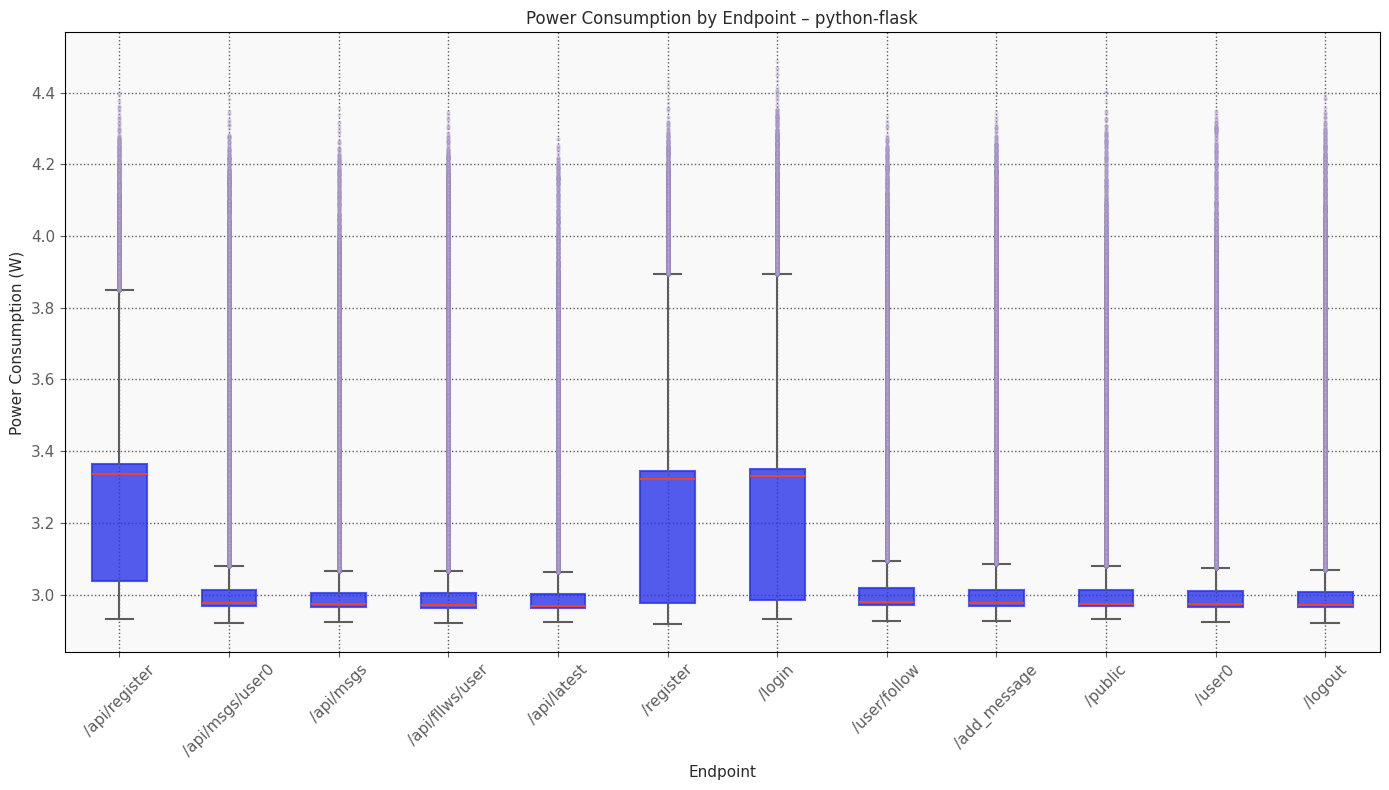

In [7]:
import matplotlib.pyplot as plt

weact_service = 'python-flask' # define service to be ploted
metric = 'power' # define metric to be ploted

# Define custom styles
labels_fontsize = 11
labels_fontcolor = "#2A2A2A"
title_fontsize = 12
tick_color = "#5D5D5D"

# Assuming data_dict contains data grouped by endpoints
labels = list(data_dict[weact_service]['endpoint'].unique())  # Unique endpoints
colors = ['#2933EB' for _ in labels]  # Define blue colors for all endpoints
median_color = "#EB4532"

# Customize flier properties for outliers
flierprops = {
        'marker': 'o',
        'markerfacecolor': '#D7B0FF',
        'markeredgecolor': '#978AB5',
        'markersize': 2,
        'linestyle': 'none',
        'alpha': 0.2,
}

# Prepare the data for boxplot (group 'power' by 'endpoint')
grouped_data_power = [data_dict[weact_service][data_dict[weact_service]['endpoint'] == endpoint][metric] for endpoint in labels]

# Plotting
fig, ax = plt.subplots(figsize=(14, 8), facecolor='white')
ax.set_facecolor('#F9F9F9')

# Box plot with custom styles
bplot = ax.boxplot(grouped_data_power, labels=labels, patch_artist=True, flierprops=flierprops, widths=0.5)

# Customize the appearance of the box plot
customize_boxplot(bplot, colors, tick_color, median_color)

# Set title and labels
title, x_label, y_label = define_title_xlable_ylable(metric)
ax.set_title(f'{title} – {weact_service}', color=labels_fontcolor, fontsize=title_fontsize)
ax.set_ylabel(f'{y_label}', color=labels_fontcolor, fontsize=labels_fontsize)
ax.set_xlabel(f'{x_label}', color=labels_fontcolor, fontsize=labels_fontsize)

# Adjust the tick parameters for better visibility
ax.tick_params(labelsize=labels_fontsize, color=tick_color, labelcolor=tick_color)
ax.tick_params(axis='x', labelsize=labels_fontsize, rotation=45, labelcolor=tick_color)

# Add grid for readability
ax.grid(True, linestyle='dotted', linewidth=1.0, color=tick_color)
ax.autoscale(enable=True, axis="y", tight=False)

# Optionally set y-axis limits for better visualization
# ax.set_ylim(2.8, 4.0) # deactivate first run 

# Show the plot
plt.tight_layout()
plt.show()

In [153]:
# save the plot
save_plot(fig, weact_service, filename_suffix=metric)

Plot for go-gorilla (sequential) saved as delta at plots/go-gorilla/sequential


---
### Boxplot: Plots all `metrics` for all `endpoints` and makes comparison for two defined services
* Define two services to compare
* Define the metric to compare

/var/folders/gb/tnf1yptj0gl7g0718ztgp6340000gn/T/ipykernel_24005/2233533894.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(


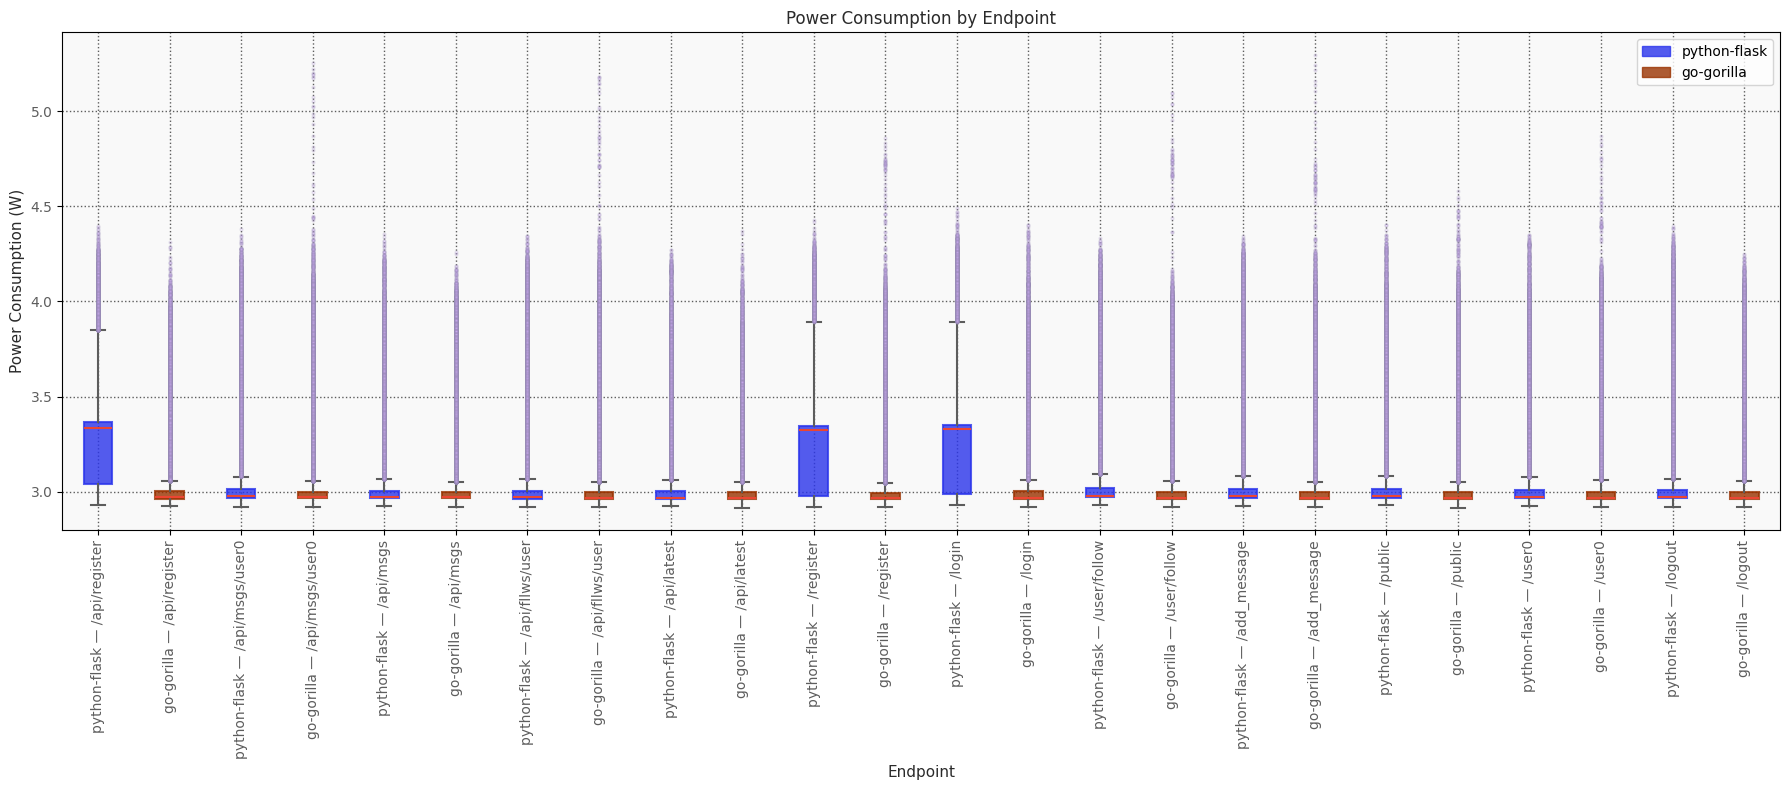

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# TODO: SH - Split this graph into comparrison of page and api endpoints
# Define services and endpoints
services = ['python-flask', 'go-gorilla']  # Define services to compare
metric = 'power'  # Define the metric to compare - possible power, delta, energy

endpoints = data_dict['python-flask']['endpoint'].unique() # define one service where all endpoints are available

# Prepare data for plotting
grouped_data = []
labels = []
group_colors = ['#2933EB', '#993200']  # Colors for the services (blue, green) currently
legend_labels = services # 

for endpoint in endpoints:
    for service in services:
        # grouping 
        df_service = data_dict[service]
        service_endpoint_data = df_service[df_service['endpoint'] == endpoint][metric]
        grouped_data.append(service_endpoint_data)
        labels.append(f"{service} — {endpoint}")

# Plotting
fig, ax = plt.subplots(figsize=(18, 8), facecolor='white')
ax.set_facecolor('#F9F9F9')

# Box plot
bplot = ax.boxplot(
    grouped_data,
    patch_artist=True,
    widths=0.4,
    labels=labels,
    flierprops=flierprops
)

for i, patch in enumerate(bplot['boxes']):
    patch.set(facecolor=group_colors[i % 2], alpha=0.8)  # Alternate colors for services
    patch.set(color=group_colors[i % 2], linewidth=1.5)
    patch.set(linewidth=1.5)  # Set border width
    
customize_boxplot(bplot, group_colors, tick_color, median_color)

# Set title and labels
title, x_label, y_label = define_title_xlable_ylable(metric)
ax.set_title(f'{title}', color=labels_fontcolor, fontsize=title_fontsize)
ax.set_ylabel(f'{y_label}', color=labels_fontcolor, fontsize=labels_fontsize)
ax.set_xlabel(f'{x_label}', color=labels_fontcolor, fontsize=labels_fontsize)

# Customize tick labels
ax.tick_params(axis='x', labelsize=10, rotation=90, labelcolor='#5D5D5D')
ax.tick_params(axis='y', labelsize=10, labelcolor='#5D5D5D')
ax.grid(True, linestyle='dotted', linewidth=1.0, color=tick_color)

# Add legend
handles = [plt.Rectangle((0, 0), 1, 1, color=color, alpha=0.8) for color in group_colors]
ax.legend(handles, legend_labels, loc='upper right', fontsize=10)

# Optional set y-axis limits for better visualization
# ax.set_ylim(0.3, 2.0)

# Show the plot
plt.tight_layout()
plt.show()

In [13]:
# save the plot
save_plot(fig, f'{"_".join(services)}_boxplot', plot_type="compare-sequential", filename_suffix=metric)

Plot for python-flask_go-gorilla_boxplot (compare-sequential) saved as energy at plots/compare-sequential
